# NMDB – Convenient Downloader for Neutron Monitor Data (Python + pandas)

This notebook provides helper functions to download **NMDB** (Neutron Monitor Database)  
count rates directly into **pandas DataFrames**, for multiple stations and long time spans.

Key features:

- Works directly with the `draw_graph.php` interface used by NMDB.
- Automatically skips comments and metadata in the ASCII response.
- Detects which stations are actually present in each month, while keeping a
  consistent set of columns (one per station).
- Handles variable station availability: if a station has no data in a given month,
  its column is present but filled with NaNs for that period.
- Provides convenience functions:
  - `nmdb_month_df(year, month, stations, ...)`
  - `nmdb_year_df(year, stations, ...)`

You can adapt the station list, year, data type (`dtype`), and time resolution
(`tresolution`) as needed for your own analysis.

## Authorship and Usage Notes

This notebook and all helper functions to access and structure NMDB data into pandas DataFrames were authored by **Dr. David Sierra-Porta** (Universidad Tecnológica de Bolívar, Cartagena, Colombia, dporta at utb.edu.co).

The code is intended as an open resource for the cosmic-ray and space-weather communities. You may freely reuse, modify, and extend it for non-commercial research and teaching. If you build on this notebook in your own work, please acknowledge the author and, when appropriate, cite the notebook or repository where it is hosted.

Please remember that the **data themselves** are provided by the NMDB (Neutron Monitor Database) and the individual station PIs, and must be acknowledged following the standard NMDB citation and station acknowledgments.

In [1]:
# NMDB helper functions: download monthly / yearly neutron monitor data
# in a robust way, directly into pandas DataFrames.

import re
import requests
import pandas as pd
from io import StringIO
from calendar import monthrange

# Base URL for NMDB "draw_graph" interface
BASE_URL = "https://www.nmdb.eu/nest/draw_graph.php"

In [2]:
def nmdb_month_df(year, month, stations,
                  dtype="corr_for_efficiency",
                  tresolution=2):
    """
    Download one month of NMDB data and return a tidy pandas DataFrame.

    Parameters
    ----------
    year : int
        Year (e.g. 2000).
    month : int
        Month as integer 1–12.
    stations : list of str
        List of requested station codes, e.g.
        ["MXCO", "JUNG1", "LMKS", "NEWK", "KERG", "OULU", "THUL", "SOPO"].
    dtype : str, optional
        NMDB data type, e.g. "corr_for_efficiency", "count_rate", etc.
    tresolution : int, optional
        Time resolution in minutes (as used by NMDB).

    Returns
    -------
    df : pandas.DataFrame
        DataFrame with columns:
          - "DATETIME" (UTC timestamps)
          - one column per station in `stations` (float, NaN where missing)

        If a station is requested but not available for that month, the column
        will be filled with NaNs for that month, but still present.

    Notes
    -----
    - NMDB sometimes returns only a subset of the requested stations for
      a given time range. We detect which stations actually appear in the
      header and then add empty columns for the missing ones, so the
      column layout is consistent across months.
    - Lines that do not look like data (e.g. header, comments, legal text)
      are ignored.
    """

    last_day = monthrange(year, month)[1]

    # Parameters are essentially those encoded in the NMDB query URL
    params = {
        "formchk": 1,
        "stations[]": stations,
        "tabchoice": "revori",
        "dtype": dtype,
        "tresolution": tresolution,
        "force": 1,
        "yunits": 0,
        "date_choice": "bydate",
        "start_day": 1,
        "start_month": month,
        "start_year": year,
        "start_hour": 0,
        "start_min": 0,
        "end_day": last_day,
        "end_month": month,
        "end_year": year,
        "end_hour": 23,
        "end_min": 59,
        "output": "ascii",
    }

    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()
    lines = response.text.splitlines()

    # ------------------------------------------------------------------
    # 1) Detect the station header line.
    #    It is a non-comment, non-empty line that appears just before the
    #    actual data and does NOT start with a timestamp.
    # ------------------------------------------------------------------
    header_line = None
    for ln in lines:
        if ln.startswith("#"):
            continue
        if not ln.strip():
            continue
        # If it's already a timestamp, we've reached the data block.
        if re.match(r'^\s*\d{4}-\d{2}-\d{2}\s', ln):
            break
        header_line = ln

    if header_line is not None:
        # Example: "                       MXCO    KERG    OULU    SOPO"
        stations_in_file = header_line.split()
    else:
        # Fallback: assume all requested stations are present (rare case).
        stations_in_file = stations

    # ------------------------------------------------------------------
    # 2) Extract only the data lines, which start with "YYYY-MM-DD ..."
    # ------------------------------------------------------------------
    data_lines = [
        ln for ln in lines
        if re.match(r'^\s*\d{4}-\d{2}-\d{2}\s', ln)
    ]

    if not data_lines:
        raise ValueError(f"No data lines found for {year}-{month:02d}. "
                         "Check that the stations / dates are valid and NMDB has data.")

    # Columns as they appear in the file: DATETIME + stations_in_file
    file_columns = ["DATETIME"] + stations_in_file

    # ------------------------------------------------------------------
    # 3) Read into a DataFrame using only valid data lines
    # ------------------------------------------------------------------
    df = pd.read_csv(
        StringIO("\n".join(data_lines)),
        sep=";",
        header=None,
        names=file_columns,
        na_values=["null"],
        on_bad_lines="skip",  # ignore malformed lines instead of failing
        engine="python",
    )

    # ------------------------------------------------------------------
    # 4) Parse timestamps and drop any rows where DATETIME is invalid
    # ------------------------------------------------------------------
    df["DATETIME"] = pd.to_datetime(df["DATETIME"].str.strip(),
                                    errors="coerce", utc=True)
    df = df.dropna(subset=["DATETIME"]).reset_index(drop=True)

    # ------------------------------------------------------------------
    # 5) Add missing station columns (requested but not present in file)
    # ------------------------------------------------------------------
    for st in stations:
        if st not in df.columns:
            df[st] = pd.NA

    # ------------------------------------------------------------------
    # 6) Reorder columns: DATETIME + stations (in requested order)
    # ------------------------------------------------------------------
    ordered_cols = ["DATETIME"] + list(stations)
    df = df[ordered_cols]

    return df


def nmdb_year_df(year, stations, dtype="corr_for_efficiency", tresolution=2):
    """
    Download a full year of NMDB data for a set of stations and return
    a single concatenated DataFrame.

    Months with no data (e.g., future months in the current year or
    months where NMDB has no records for the requested stations) are
    skipped gracefully.

    Parameters
    ----------
    year : int
        Year (e.g. 2000, 2018, 2025, etc.).
    stations : list of str
        Station list, e.g.
        ["MXCO", "JUNG1", "LMKS", "NEWK", "KERG", "OULU", "THUL", "SOPO"].
    dtype : str, optional
        NMDB data type (passed to `nmdb_month_df`).
    tresolution : int, optional
        Time resolution in minutes (passed to `nmdb_month_df`).

    Returns
    -------
    df_year : pandas.DataFrame
        Concatenated DataFrame for the whole year (for the months that
        actually have data), with columns:
        "DATETIME" + stations (in the given order).
    """

    monthly_dfs = []

    for month in range(1, 13):
        print(f"Downloading {year}-{month:02d} ...", flush=True)
        try:
            df_m = nmdb_month_df(
                year=year,
                month=month,
                stations=stations,
                dtype=dtype,
                tresolution=tresolution,
            )
        except ValueError as e:
            # No data lines found for this month (e.g., future month)
            print(f"  -> Skipping {year}-{month:02d}: {e}")
            continue
        except requests.HTTPError as e:
            # HTTP error from NMDB (network issue, server error, etc.)
            print(f"  -> Skipping {year}-{month:02d} due to HTTP error: {e}")
            continue

        if not df_m.empty:
            monthly_dfs.append(df_m)
        else:
            print(f"  -> Skipping {year}-{month:02d}: empty DataFrame returned.")

    if not monthly_dfs:
        raise RuntimeError(
            f"No monthly data could be retrieved for year {year}. "
            "Check the station list and the availability of NMDB data."
        )

    # Concatenate all available months
    df_year = pd.concat(monthly_dfs, ignore_index=True)

    # Sort chronologically and drop repeated timestamps (if any)
    df_year = df_year.sort_values("DATETIME").reset_index(drop=True)
    df_year = df_year.drop_duplicates(subset="DATETIME", keep="first").reset_index(drop=True)

    return df_year

In [3]:
# Example station list (modify as needed)
stations = ["MXCO", "JUNG1", "LMKS", "NEWK", "KERG", "OULU", "THUL", "SOPO"]

year = 2024

# ------------------------------------------------------------
# Example 1: Download a single month (e.g. January 2024)
# ------------------------------------------------------------
df_jan_2024 = nmdb_month_df(2024, 1, stations)
print("January 2024:", df_jan_2024.shape)
display(df_jan_2024.head())

# Save January 2024 to CSV
# Uncomment if needed
# df_jan_2024.to_csv("nmdb_2024_01_all_stations.csv", index=False)

# ------------------------------------------------------------
# Example 2: Download a full year (e.g. 2024) and save to CSV
# ------------------------------------------------------------
df_2024 = nmdb_year_df(2024, stations)
print("Year 2024:", df_2024.shape)
display(df_2024.head())

# Uncomment if needed
# df_2000.to_csv("nmdb_2000_all_stations.csv", index=False)
# print("Saved file: nmdb_2000_all_stations.csv")

January 2024: (22320, 9)


,DATETIME,MXCO,JUNG1,LMKS,NEWK,KERG,OULU,THUL,SOPO
0,2024-01-01 00:00:00+00:00,214.658,358.485,418.843,90.210,207.161,98.699,111.950,266.060
1,2024-01-01 00:02:00+00:00,217.325,358.473,419.281,90.085,207.267,98.385,111.185,266.090
2,2024-01-01 00:04:00+00:00,219.917,357.844,423.451,89.950,205.546,97.859,112.950,270.065
3,2024-01-01 00:06:00+00:00,222.942,357.123,423.805,90.505,208.179,95.474,110.820,267.955
4,2024-01-01 00:08:00+00:00,220.875,357.773,423.111,89.500,205.746,98.402,113.380,267.140


Year 2024: (263520, 9)


,DATETIME,MXCO,JUNG1,LMKS,NEWK,KERG,OULU,THUL,SOPO
0,2024-01-01 00:00:00+00:00,214.658,358.485,418.843,90.210,207.161,98.699,111.950,266.06
1,2024-01-01 00:02:00+00:00,217.325,358.473,419.281,90.085,207.267,98.385,111.185,266.09
2,2024-01-01 00:04:00+00:00,219.917,357.844,423.451,89.950,205.546,97.859,112.950,270.065
3,2024-01-01 00:06:00+00:00,222.942,357.123,423.805,90.505,208.179,95.474,110.820,267.955
4,2024-01-01 00:08:00+00:00,220.875,357.773,423.111,89.500,205.746,98.402,113.380,267.14


In [4]:
df_jan_2024["DATETIME"]=pd.to_datetime(df_jan_2024["DATETIME"])
df_jan_2024.index=df_jan_2024["DATETIME"]
df_jan_2024.index.name = None
df_jan_2024=df_jan_2024.drop(columns=["DATETIME"])
for i in df_jan_2024.columns:
    df_jan_2024[i]=pd.to_numeric(df_jan_2024[i],errors='coerce')
df_2024["DATETIME"]=pd.to_datetime(df_2024["DATETIME"])
df_2024.index=df_2024["DATETIME"]
df_2024.index.name = None
df_2024=df_2024.drop(columns=["DATETIME"])
for i in df_2024.columns:
    df_2024[i]=pd.to_numeric(df_2024[i],errors='coerce')

In [5]:
df_2024

,MXCO,JUNG1,LMKS,NEWK,KERG,OULU,THUL,SOPO
2024-01-01 00:00:00+00:00,214.658,358.485,418.843,90.210,207.161,98.699,111.950,266.060
2024-01-01 00:02:00+00:00,217.325,358.473,419.281,90.085,207.267,98.385,111.185,266.090
2024-01-01 00:04:00+00:00,219.917,357.844,423.451,89.950,205.546,97.859,112.950,270.065
2024-01-01 00:06:00+00:00,222.942,357.123,423.805,90.505,208.179,95.474,110.820,267.955
2024-01-01 00:08:00+00:00,220.875,357.773,423.111,89.500,205.746,98.402,113.380,267.140
...,...,...,...,...,...,...,...,...
2024-12-31 23:50:00+00:00,207.625,323.824,389.278,83.735,194.787,91.203,106.840,249.515
2024-12-31 23:52:00+00:00,210.267,332.794,387.023,84.640,196.108,91.872,107.955,244.005
2024-12-31 23:54:00+00:00,206.991,329.885,393.481,84.550,193.040,93.613,106.985,248.065
2024-12-31 23:56:00+00:00,207.642,329.504,389.554,85.380,195.680,92.465,111.410,245.125


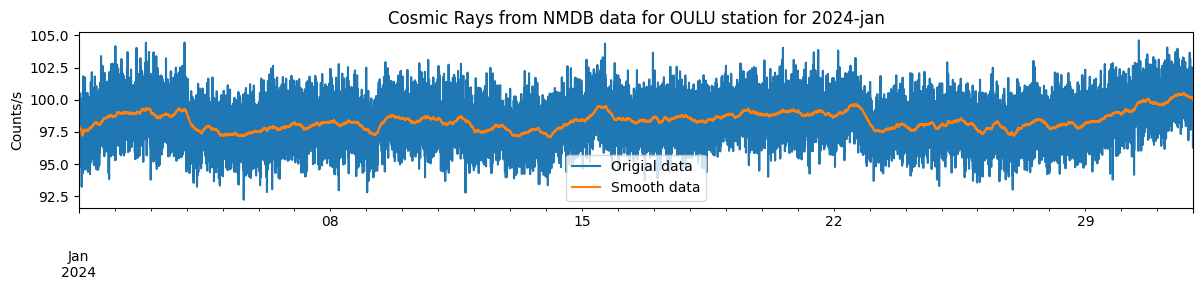

In [6]:
import matplotlib.pyplot as plt
df_jan_2024["OULU"].plot(figsize=(12,3),label="Origial data")
df_jan_2024["OULU"].ewm(alpha=0.01).mean().plot(figsize=(12,3),label="Smooth data")
plt.title("Cosmic Rays from NMDB data for OULU station for 2024-jan")
plt.ylabel("Counts/s");
plt.legend()
plt.tight_layout(); plt.show()

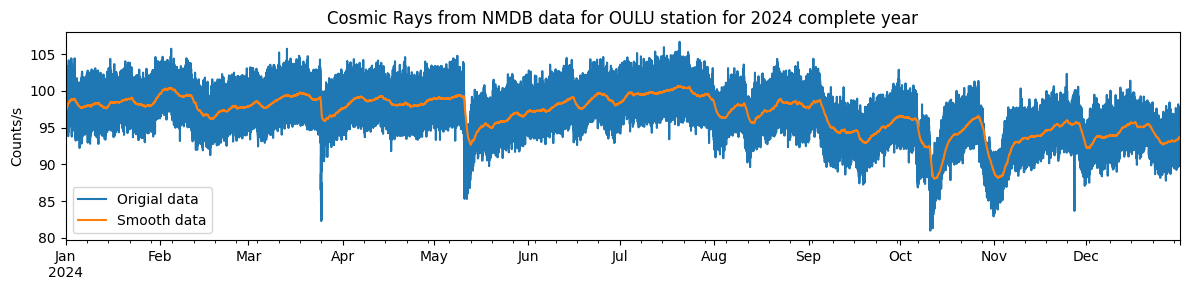

In [7]:
import matplotlib.pyplot as plt
df_2024["OULU"].plot(figsize=(12,3),label="Origial data")
df_2024["OULU"].ewm(alpha=0.001).mean().plot(figsize=(12,3),label="Smooth data")
plt.title("Cosmic Rays from NMDB data for OULU station for 2024 complete year")
plt.ylabel("Counts/s");
plt.legend()
plt.tight_layout(); plt.show()

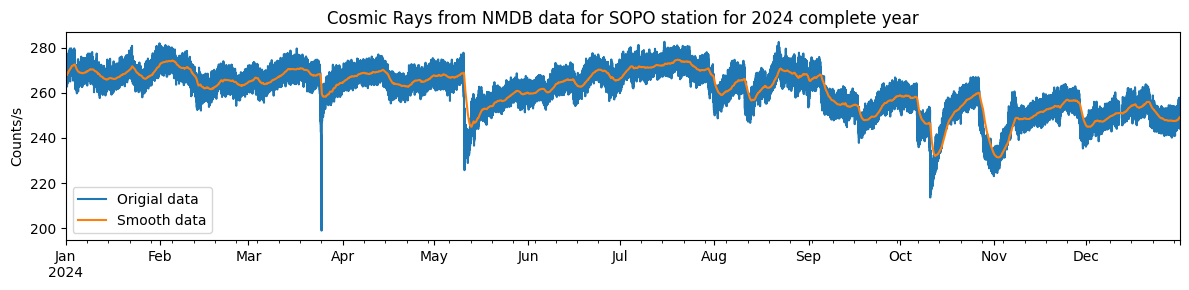

In [8]:
import matplotlib.pyplot as plt
df_2024["SOPO"].plot(figsize=(12,3),label="Origial data")
df_2024["SOPO"].ewm(alpha=0.001).mean().plot(figsize=(12,3),label="Smooth data")
plt.title("Cosmic Rays from NMDB data for SOPO station for 2024 complete year")
plt.ylabel("Counts/s");
plt.legend()
plt.tight_layout(); plt.show()